In [302]:
import pandas as pd
import numpy as np
import scipy as sp
import random
from scipy.stats import chi2

#from __future__ import print_function
import time
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [303]:
data = pd.read_json("BaseMap.json")
data = data[2:].copy().reset_index(drop=True)
data

,type,colormap
0,bird_black_1,"[{'x': 0.0, 'y': 0.108359135687351}, {'x': 36...."
1,bird_black_2,"[{'x': 0.0, 'y': 0.122055672109127}, {'x': 36...."
2,bird_black_3,"[{'x': 0.0, 'y': 0.13507853448390902}, {'x': 3..."
3,bird_black_4,"[{'x': 0.0, 'y': 0.108540922403335}, {'x': 36...."
4,bird_black_5,"[{'x': 0.0, 'y': 0.085764810442924}, {'x': 36...."
...,...,...
263,novel_object_10_1_11,"[{'x': 224.0, 'y': 0.061946902424097006}, {'x'..."
264,novel_object_11_1_11,"[{'x': 160.0, 'y': 0.38983049988746604}, {'x':..."
265,novel_object_7_1_11,"[{'x': 160.0, 'y': 0.39711192250251703}, {'x':..."
266,novel_object_0_1_12,"[{'x': 0.0, 'y': 0.109271526336669}, {'x': 223..."


In [304]:
split_type = data['type'].str.split('_')

In [305]:
object_name = []
for item in split_type:
    #print(item[0])
    if item[0]=='bird':
        object_name.append(item[0]+"_"+item[1])
    elif item[0]=='novel':
        object_name.append(item[0]+"_"+item[1]+"_"+item[3]+"_"+item[4])
    else:
        object_name.append(item[0])

In [306]:
data['name'] = object_name

In [307]:
def colormapfunction(row):
    per = list(np.zeros(256))

    for item in row:
        per[int(item['x'])] = item['y']
    return per

In [308]:
colarray = []
for item in data['colormap']:
    row = item
    colarray.append(colormapfunction(item))
    
X = np.array(colarray).reshape(-1,256)
X.shape

(268, 256)

In [309]:
#creating the inputs for model
feat_cols = [ 'color '+str(i) for i in range(X.shape[1]) ]
DF = pd.DataFrame(X,columns=feat_cols)

DF['name'] = object_name

# pd.set_option('display.max_columns', None) # Show All Columns in Preview
# DF
print('Size of the dataframe: {}'.format(DF.shape))

Size of the dataframe: (268, 257)


In [310]:
# For reproducability of the results
np.random.seed(42)
rndperm = np.random.permutation(data.shape[0])
rndperm
len(rndperm)

268

In [311]:
# #check pca
# pca = PCA(n_components=3)
# pca_result = pca.fit_transform(DF[feat_cols].values)
# DF['pca-one'] = pca_result[:,0]
# DF['pca-two'] = pca_result[:,1] 
# DF['pca-three'] = pca_result[:,2]
# print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))


In [312]:
len(set(object_name))

18

In [313]:
# plt.figure(figsize=(10,10))
# sns.scatterplot(
#     x="pca-one", y="pca-two",
#     hue="name",
#     palette=sns.color_palette("hls", 18),
#     data=DF.loc[rndperm,:],
#     legend="full",
#     alpha=0.3
# )

In [314]:
#Check T-SNE
N = 10000
df_subset = DF.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values

In [315]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=500)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 268 samples in 0.000s...
[t-SNE] Computed neighbors for 268 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 268 / 268
[t-SNE] Mean sigma: 0.306953
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.274452
[t-SNE] KL divergence after 500 iterations: 0.118304
t-SNE done! Time elapsed: 0.30170321464538574 seconds


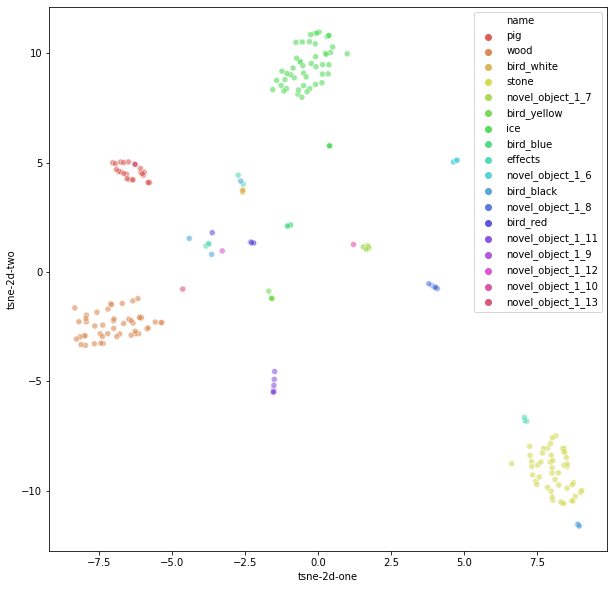

In [316]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(10,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="name",
    palette=sns.color_palette("hls", 18),
    data=df_subset,
    legend="full",
    alpha=0.6
)

In [317]:
## Calculating Mahalanobis Distances using DF
list(DF['name'].unique())

['bird_black',
 'bird_blue',
 'bird_red',
 'bird_white',
 'bird_yellow',
 'effects',
 'ice',
 'pig',
 'stone',
 'wood',
 'novel_object_1_6',
 'novel_object_1_7',
 'novel_object_1_8',
 'novel_object_1_9',
 'novel_object_1_10',
 'novel_object_1_11',
 'novel_object_1_12',
 'novel_object_1_13']

In [318]:
object_to_check = DF[DF['name']=='novel_object_1_9'].copy()
object_to_check.drop(['name'],axis=1,inplace=True)

In [319]:
woodobjects = DF[DF['name']=='wood'].reset_index()
woodobjects.drop(['name','index'],axis=1,inplace=True)

In [320]:
data_to_generate = int(1000/len(woodobjects))
data_to_generate

20

In [321]:
noise_degree = 2

noisy_data = []
for i in range(len(woodobjects)):
    #print(woodobjects.iloc[0,j])
    for j in range(data_to_generate):
        random_data = woodobjects.iloc[i]+np.random.uniform(-1,1,256)*noise_degree/100
        random_data = [ x if x>0 else 0 for x in random_data ]
        random_data = random_data/(np.ones(256)*sum(random_data))
        noisy_data.append(random_data)
   

In [322]:
len(noisy_data)

960

In [323]:
noisy_data = pd.DataFrame(noisy_data)
noisy_data.columns = woodobjects.columns
noisy_data

,color 0,color 1,color 2,color 3,color 4,color 5,color 6,color 7,color 8,color 9,...,color 246,color 247,color 248,color 249,color 250,color 251,color 252,color 253,color 254,color 255
0,0.000093,0.001613,0.000000,0.001178,0.006575,0.000962,0.003747,0.005181,0.008293,0.001751,...,0.000000,0.000000,0.003321,0.000000,0.000553,0.007842,0.000000,0.006694,0.008340,0.000000
1,0.006895,0.000290,0.007320,0.001284,0.002919,0.000788,0.006563,0.004212,0.000383,0.006629,...,0.006446,0.000000,0.001592,0.001777,0.000000,0.000000,0.000000,0.006909,0.000000,0.000000
2,0.000000,0.003157,0.000000,0.000000,0.001638,0.008359,0.000000,0.000000,0.000000,0.001967,...,0.005005,0.000000,0.003197,0.000000,0.000000,0.005365,0.006796,0.002022,0.000127,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000183,0.006126,0.000000,...,0.005935,0.002165,0.003538,0.000000,0.000729,0.000455,0.006555,0.006403,0.006265,0.000000
4,0.004432,0.004594,0.003168,0.004551,0.006073,0.000000,0.000036,0.000000,0.000000,0.002546,...,0.000000,0.000000,0.000000,0.003891,0.000000,0.007199,0.004256,0.000000,0.002021,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,0.006651,0.003935,0.000000,0.000000,0.000000,0.000000,0.000000,0.004654,0.000000,0.005336,...,0.000000,0.000000,0.000000,0.000000,0.003223,0.007814,0.000000,0.000000,0.000000,0.001963
956,0.001213,0.004745,0.006369,0.004500,0.000706,0.000000,0.007737,0.007098,0.002343,0.000000,...,0.000000,0.006290,0.000000,0.000000,0.003559,0.000000,0.008606,0.003769,0.000000,0.005761
957,0.000000,0.000000,0.000000,0.000000,0.002466,0.000000,0.004911,0.001355,0.003748,0.002440,...,0.002433,0.000000,0.006441,0.000000,0.000669,0.000000,0.006022,0.000000,0.000000,0.007249
958,0.000000,0.000000,0.006921,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004814,...,0.000000,0.004746,0.006169,0.005765,0.000000,0.006596,0.000000,0.003577,0.000000,0.008402


In [324]:
 #pd.concat([woodobjects,noisy_data])

In [325]:
woodobjects = pd.concat([object_to_check,woodobjects,noisy_data])
woodobjects.reset_index(drop=True,inplace=True)

In [327]:
woodobjects = woodobjects.loc[:,(woodobjects!=0).any(axis=0)]
woodobjects.shape

(1009, 256)

In [328]:
#Function to calculate mahalanobis distance

def mahalanobis(x=None, data=None, cov=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = sp.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

In [329]:
names = woodobjects.columns
names = list(names)
dof = len(woodobjects.columns)

In [330]:
woodobjects['mahalanobis'] = mahalanobis(x=woodobjects, data=woodobjects[names])
woodobjects.head()

,color 0,color 1,color 2,color 3,color 4,color 5,color 6,color 7,color 8,color 9,...,color 247,color 248,color 249,color 250,color 251,color 252,color 253,color 254,color 255,mahalanobis
0,0.048259,0.0,0.0,0.0,0.038766,0.0,0.0,0.0,0.003165,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,969.331927
1,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,107.648948
2,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,106.547819
3,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101.533625
4,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.898569


In [331]:
dof

256

In [332]:
# Critical values for n degrees of freedom
#df = total number of variables
#p value = 0.001 or something really small to make sure it's an actual outlier

chi2.ppf((1-0.001), df=dof)

331.65639454546084

In [335]:
# Compute the P-Values
woodobjects['p_value'] = 1 - chi2.cdf(woodobjects['mahalanobis'], dof)

# Extreme values with a significance level of 0.01
different_objects = woodobjects.loc[woodobjects.p_value < 0.001] 

In [356]:
diff = 'yes' if 0 in list(different_objects.index) else 'no'
    
distance = woodobjects['mahalanobis'][0]
pvalue = woodobjects['p_value'][0]

In [357]:
diff

'yes'

0.0